In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import re
import ast
import unicodedata
import seaborn as sns
import warnings
from openai import OpenAI
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")


Nombre d'articles retirés après premier filtre : 112
Nombre de caractères totaux avant nettoyage : 50853943
Nombre de caractères totaux après nettoyage : 50166920


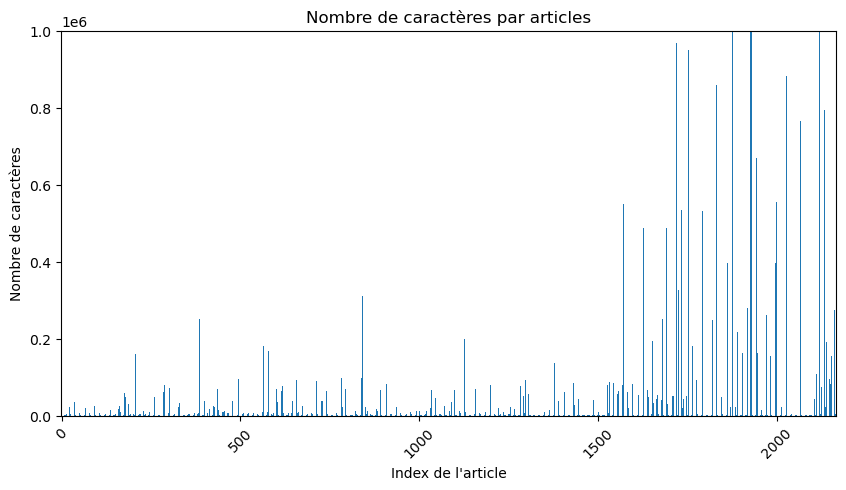

In [2]:
ecb_press = pd.read_parquet('../data/ecb_press.parquet')
ecb_press['content'].str.len().plot(kind='bar',
                                    xticks=np.arange(0, ecb_press.shape[0],500),
                                    title="Nombre de caractères par articles",
                                    ylim=(0, 1e6), 
                                    figsize=(10,5),
                                    xlabel="Index de l'article", ylabel='Nombre de caractères')

plt.xticks(rotation=45)

ecb_press_filtered = ecb_press.loc[ecb_press.content.str.len()<= 250000].reset_index(drop=True).copy()
print("Nombre d'articles retirés après premier filtre :", ecb_press.shape[0] - ecb_press_filtered.shape[0])
def nettoyer_texte(texte):
    if pd.isnull(texte):
        return texte
    texte = re.sub(r'[\n\t\r]+', ' ', texte)
    texte = re.sub(r'\s{2,}', ' ', texte)
    texte = re.sub(r'[^\w\s.,;:!?\'"-]', '', texte)
    texte = texte.strip()
    texte = texte.lower()
    return texte

print('Nombre de caractères totaux avant nettoyage :', ecb_press_filtered.content.str.len().sum())
ecb_press_filtered['content'] = ecb_press_filtered['content'].apply(lambda x: nettoyer_texte(x))
print('Nombre de caractères totaux après nettoyage :', ecb_press_filtered.content.str.len().sum())

In [3]:
ecb_sentiment_ = pd.read_csv('../data/ecb_sentiment_article.csv', index_col=0).reset_index(drop=True)
glob = pd.concat([ecb_press_filtered, ecb_sentiment_], axis=1)
glob = glob.set_index('date')
glob['year'] = glob.index.year
glob.head(2)


,language,url,content,title_2,global_sentiment_score,global_sentiment_category,market_relevance_score,Banks_sentiment_score,Banks_relevance_score,Oil & Gas_sentiment_score,Oil & Gas_relevance_score,Technology_sentiment_score,Technology_relevance_score,Healthcare_sentiment_score,Healthcare_relevance_score,Utilities_sentiment_score,Utilities_relevance_score,key_points,keywords,year
date,,,,,,,,,,,,,,,,,,,,
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,feedback on fit in the ecosystem consultation ...,PDF Title,0.6,Positive,1.0,0.5,1.0,0.0,0.0,0.7,1.0,0.0,0.0,0.0,0.0,Digital euro will increase competition in the ...,digital euro | payment sector | competition | ...,2024
2024-12-12,en,https://www.ecb.europa.eu/euro/digital_euro/ti...,ecb-public preliminary methodology for calibra...,PDF Title,0.6,Positive,1.0,0.7,1.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,0.0,ECB is developing a methodology for setting di...,digital euro | holding limits | monetary polic...,2024


TF-IDF to study the words the most impactful

In [42]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=1000,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0015)),
    ]
)

In [43]:
glob['global_sentiment_category'].unique()

array(['Positive', 'Neutral', 'Negative', nan], dtype=object)

In [44]:
glob_ = pd.get_dummies(glob, columns=['global_sentiment_category'])

In [45]:
X = glob["content"]
interpret_coefs = {}
for c in ["global_sentiment_category_Negative", "global_sentiment_category_Neutral", "global_sentiment_category_Positive"]:
    y = glob_[c]
    est.fit(X, y)
    vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(
        np.transpose(est.named_steps["reg"].coef_), index=vocab_
    )
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}

In [46]:
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np

def bar(
    df,
    err=None,
    sort=True,
    figsize=(8, 5),
    ax=None,
    title=None,
    horizontal=False,
    baseline=None,
    rotation=0,
):
    if isinstance(df, pd.DataFrame):
        df = df.squeeze()
    if isinstance(df, dict):
        df = pd.Series(df)
    if sort:
        df = df.sort_values()
    if err is not None:
        err = err.loc[df.index]
    labels = df.index
    x = np.arange(len(labels))
    fig, ax = set_axis(ax=ax, figsize=figsize, title=title)
    if horizontal:
        ax.barh(x, df.values, xerr=err, capsize=5)
        ax.set_yticks(x)
        ax.set_yticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.barh(x, df_.values, color="lightgreen")
    else:
        ax.bar(x, df.values, yerr=err, capsize=5)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=0)
        if baseline in df.index:
            df_ = df.copy()
            df_[df.index != baseline] = 0
            ax.bar(x, df_.values, color="lightgreen")
    ax.set_title(title)


def set_axis(ax=None, figsize=(8, 5), title=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    if title is not None:
        ax.set_title(title)
    return fig, ax


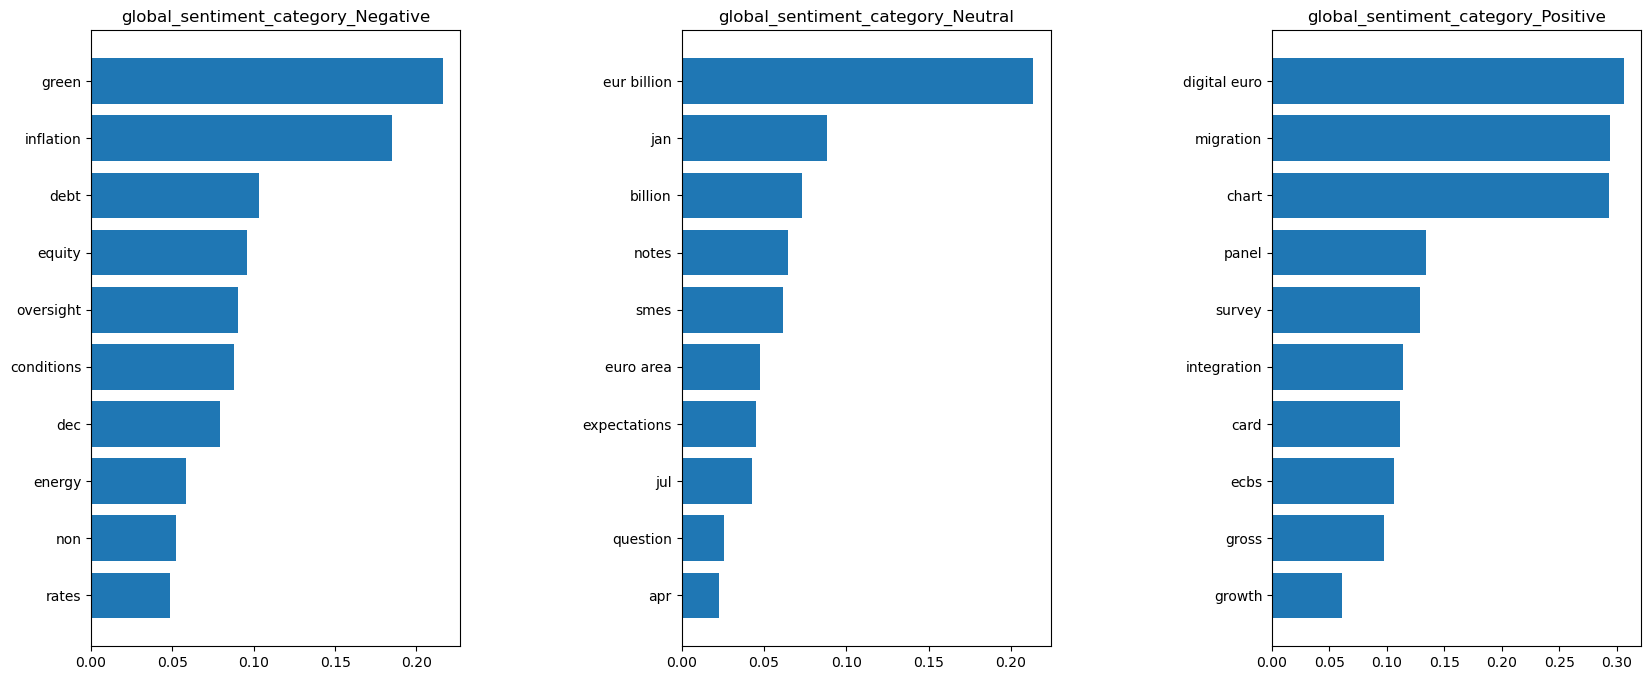

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=0.6)
for i, (k, v) in enumerate(d.items()):
    bar(v, horizontal=True, ax=ax[i], title=k)

In [7]:
tfidf = TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            )

In [8]:
tfidf.fit_transform(glob['content'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 267888 stored elements and shape (2056, 500)>

In [ ]:
X = glob["content"]
interpret_coefs = {}
for c in ["hawkish", "neutral", "dovish"]:
    y = statements_[c]
    est.fit(X, y)
    vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(
        np.transpose(est.named_steps["reg"].coef_), index=vocab_
    )
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}

In [ ]:
glob['global_sentiment_category']

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

vectorizer = TfidfVectorizer(
    vocabulary=None,
    max_features=500,      # Limite les features pour performance, ajustable
    ngram_range=(1,3),      # On peut utiliser unigrams + bigrams, ajustable
    stop_words="english",
    token_pattern=r"\b[a-zA-Z]{3,}\b",# ou 'french', selon la langue des articles
)
X = vectorizer.fit_transform(glob['content'])


# -----------------------------------------------------------------------------
# 3) Encodage du label (les catégories de sentiments)
# -----------------------------------------------------------------------------
le = LabelEncoder()
y = le.fit_transform(glob['global_sentiment_category'])
# Dans y, on aura 0, 1, 2 correspondant à ['Negative', 'Neutral', 'Positive']
# ou dans un autre ordre, selon ce que LabelEncoder a appris.


# -----------------------------------------------------------------------------
# 4) Séparation en jeu d'entraînement et de test
# -----------------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)



In [17]:
vectorizer.

AttributeError: 'TfidfVectorizer' object has no attribute 'named_steps'

In [14]:
model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.5,
    max_iter=1000,
    random_state=42
)
model.fit(X_train, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')

In [15]:
model.coef_

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.21467047,  0.        ]])

In [ ]:

# -----------------------------------------------------------------------------
# 5) Entraînement du modèle ElasticNet (LogisticRegression)
# -----------------------------------------------------------------------------
# L1_ratio=0.5 => mélange de L1 et L2 (elasticnet)
# solver='saga' => nécessaire pour penalty='elasticnet'


# Évaluation sur le test
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

